# baseline
先按照一般的步骤完成一个baseline, 然后再去进行迭代.

baseline步骤:
- 赛题理解(已完成)
- 数据分析(在DataAnalysis中完成, 在这里进行总结, 并处理数据)
    - 对某些连续特征的离散化
    - 构建连续与离散特征, 主要是归一化和编码
    - 数据清理: 去除掉离群点和异常值
- 特征工程
    - 特征选择: 去掉对模型有害的特征
    - 构造特征: 主要在之后的迭代中完成
    - 提取统计特征
    - 特征组合
- 模型训练与验证
    - 数据集的划分(训练集, 测试集, 验证集): 应独立划分, 防止特征穿越
    - 模型训练: 调参
    - 线下评测
- 模型融合

## 数据分析
### 总结
- 特征分类
    - 连续特征: GRJCJS(个人缴存基数), GRZHYE(个人账户余额), GRZHSNJZYE(个人账户上年结转余额), GRZHDNGJYE(个人账户当年归集余额), GRYJCE(个人月缴存额), DWYJCE(单位月缴存额), DKFFE(贷款发放额), DKYE(贷款余额)
    - 离散特征: XINGBIE(性别), HYZK(婚姻状况), ZHIYE(职业), ZHICHEN(职称), ZHIWU(职务), XUELI(学历), DWJJLX(单位经济类型), DWSSHY(单位所属行业), GRZHZT(个人账户状态)
    - 其他特征: CSNY(出生年月), DKLL(贷款利率)
- 特征分布:
    - 测试集与训练集分布差异较大: ZHIWU(分布不同), DKLL(训练集为8个类,测试集为数值)
    - 类别特征中在测试集中只有一类: HYZK, XUELI 
    - 类别特征中单类占主导(训练集测试集均如此): ZHIYE, ZHICHEN, GRZHZT

### 数据处理
-  CSNY: 先又时间戳转换为年份, 再把1971和大于2010的放在一类, 其他的进行分桶, 转换成了类别特征
- DKLL:
- 去掉特征: HYZK, XUELI
- 单类占主导的将所有少类合并: ZHIYE, ZHICHEN 
- 大概率为1的, 可以直接使用规则方法: GRZHZT
- 对连续特征编码


In [1]:
import numpy as np
import pandas as pd
pd.set_option("max_columns", 100)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import lightgbm as lgb
import time

In [2]:
train = pd.read_csv(r'./data/train.csv')
test = pd.read_csv(r'./data/test.csv')
submit = pd.read_csv(r'./data/submit.csv')

In [3]:
train.shape, test.shape

((40000, 21), (15000, 20))

In [4]:
train.tail(10)

,id,XINGBIE,CSNY,HYZK,ZHIYE,ZHICHEN,ZHIWU,XUELI,DWJJLX,DWSSHY,GRJCJS,GRZHZT,GRZHYE,GRZHSNJZYE,GRZHDNGJYE,GRYJCE,DWYJCE,DKFFE,DKYE,DKLL,label
39990,train_39990,2,586364400,90,90,999,0,99,900,15,3637.0,1,7477.680,19378.330,7362.525,645.00,645.00,150237,237.000,2.979,0
39991,train_39991,2,468086400,90,90,999,0,99,150,2,2237.0,1,10114.800,6797.550,1037.000,337.00,337.00,300237,284237.000,2.979,0
39992,train_39992,1,715276800,90,90,999,0,99,150,3,1192.0,1,237.000,10776.675,-159.130,284.75,284.75,135237,131149.410,2.708,0
39993,train_39993,1,78768000,90,90,999,0,99,160,2,1887.0,1,14619.845,11789.395,897.000,319.50,319.50,125237,116250.010,2.708,0
39994,train_39994,1,604684800,90,90,999,0,99,150,14,5135.0,1,20844.420,16506.840,-4796.985,824.76,824.76,150237,148496.995,2.708,0
39995,train_39995,1,573148800,90,90,999,0,99,110,16,3185.0,1,82865.575,65304.370,4026.600,590.76,590.76,150237,117816.680,2.708,0
39996,train_39996,2,57772800,90,90,999,0,99,110,14,1660.5,1,32811.585,27065.150,1603.560,407.82,407.82,300237,267615.065,2.979,0
39997,train_39997,2,673023600,90,90,999,0,99,143,9,3923.0,1,8875.695,1309.890,3185.800,605.60,605.60,175237,237.000,2.708,0
39998,train_39998,1,536428800,90,90,999,0,99,150,6,3527.0,1,2079.400,252.875,1614.490,467.30,467.30,125237,113068.900,2.708,1
39999,train_39999,1,31507200,90,90,999,0,99,110,14,4934.5,1,26210.635,27266.080,-4994.610,800.70,800.70,300237,287737.000,2.979,0


## 数据分析与处理

In [5]:
# 先把时间戳转换成年份, 再进行分箱
data = pd.concat([train, test], axis=0)
data = data.reset_index(drop=True)

def convert_time(x):
    try:
        t = time.localtime(x)
        t = time.strftime('%Y', t)
    except:
        t=1971
    t = int(t)
    return t

data['CSNY'] = data['CSNY'].apply(convert_time)

def divide_bin(x):
    if (x == 1971) | (x >= 2010):
        return 0
    if (x>1971) & (x<=1978):
        return 1
    if (x>1978) & (x<=1982):
        return 2
    if (x>1982) & (x<=1985):
        return 3
    if (x>1985) & (x<=1987):
        return 4
    if (x>1987) & (x<=1991):
        return 5
    if (x>1991) & (x<=1995):
        return 6
    if (x>1995) & (x<2010):
        return 7

data['CSNY'] = data['CSNY'].apply(divide_bin)

In [6]:
# 对ZHIYE和ZHICHEN特征进行少类合并
def combine_zhiye(x):
    if x == 90:
        return 0
    else:
        return 1

def combine_zhichen(x):
    if x == 999:
        return 0
    else:
        return 1

def combine_grzhzt(x):
    if x == 1:
        return 0
    else:
        return 1

data['ZHIYE'] = data['ZHIYE'].apply(combine_zhiye)
data['ZHICHEN'] = data['ZHICHEN'].apply(combine_zhichen)
data['GRZHZT'] = data['GRZHZT'].apply(combine_grzhzt)

In [7]:
data = data.drop(['HYZK', 'XUELI'], axis=1)

In [8]:
data['ZHIYE'].value_counts(), data['ZHICHEN'].value_counts(), data['GRZHZT'].value_counts()

(0    54930
 1       70
 Name: ZHIYE, dtype: int64,
 0    54912
 1       88
 Name: ZHICHEN, dtype: int64,
 0    54773
 1      227
 Name: GRZHZT, dtype: int64)

In [9]:
data.head(10)

,id,XINGBIE,CSNY,ZHIYE,ZHICHEN,ZHIWU,DWJJLX,DWSSHY,GRJCJS,GRZHZT,GRZHYE,GRZHSNJZYE,GRZHDNGJYE,GRYJCE,DWYJCE,DKFFE,DKYE,DKLL,label
0,train_0,1,7,0,0,0,150,12,1737.0,0,3223.515,801.310,837.000,312.00,312.00,175237,154112.935,2.708,0.0
1,train_1,2,4,0,0,0,110,0,4894.0,0,18055.195,53213.220,1065.200,795.84,795.84,300237,298252.945,2.979,0.0
2,train_2,1,6,0,0,0,150,9,10297.0,0,27426.600,13963.140,7230.020,1444.20,1444.20,150237,147339.130,2.708,0.0
3,train_3,1,3,0,0,0,150,7,10071.5,0,111871.130,99701.265,2271.295,1417.14,1417.14,350237,300653.780,2.708,0.0
4,train_4,2,4,0,0,0,900,14,2007.0,0,237.000,11028.875,35.780,325.50,325.50,150237,145185.010,2.708,0.0
5,train_5,1,3,0,0,0,150,14,1192.0,0,9648.315,7388.550,771.800,303.85,303.85,150237,149743.210,2.708,0.0
6,train_6,1,4,0,0,0,160,2,7297.0,0,22846.975,12179.565,5885.000,801.80,801.80,150237,146723.725,2.708,0.0
7,train_7,1,7,0,0,0,150,7,1399.0,0,1808.135,6405.055,1050.400,318.34,318.34,125237,64938.955,2.708,0.0
8,train_8,2,5,0,0,0,150,9,6408.0,0,79304.635,52365.820,6161.160,977.52,977.52,300237,270579.955,2.979,0.0
9,train_9,2,3,0,0,0,150,14,3573.5,0,2009.000,61126.175,536.750,637.38,637.38,230237,142296.640,2.708,0.0


In [43]:
# 确定离散特征和连续特征, 并调整特征的位置
sparse_feat = ['CSNY', 'XINGBIE', 'ZHIYE', 'ZHICHEN', 'ZHIWU', 'DWJJLX', 'DWSSHY', 'GRZHZT']
dense_feat = ['GRJCJS', 'GRZHYE', 'GRZHSNJZYE', 'GRZHDNGJYE', 'GRYJCE', 'DWYJCE', 'DKFFE', 'DKYE', 'DKLL']
feat_list = sparse_feat + dense_feat
data = data[['id'] + feat_list + ['label']]
data.shape

(55000, 19)

In [44]:
# 对连续特征编码
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
data[sparse_feat] = data[sparse_feat].apply(encoder.fit_transform)

## 特征工程

## 通过贷款利率构造特征
在训练集的DKLL字段中, 一个有8种值.这种值的含义如下:
- 2.708为一套房五年以上的月利率.
- 2.979为二套房五年以上的月利率(1.1倍)
- 3.25为一套房的五年以上的年利率
- 3.575为二套房的五年以上的年利率(1.1倍)
- 2.292为一套房五年内的月利率
- 2.521为二套房五年内的月利率(1.1倍)
- 2.75为一套房的五年内年利率
- 3.025为二套房五年内的年利率(1.1倍)

由此可以构造三个0-1类别特征, 分别表示一套房还是二套房, 是否五年以上, 是年利率还是月利率.

由于测试集中有很多其他的值, 因此可以通过区间来进行划分

In [45]:
def divide_DKLL(x):
    x = x['DKLL']
    if x<=2.4:
        return 0, 1, 1, 0
    if (x>2.4) & (x<=2.6):
        return 1, 1, 1, 1
    if (x>2.6) & (x<=2.725):
        return 0, 0, 1, 2
    if (x>2.725) & (x<=2.86):
        return 0, 1, 0, 3
    if (x>2.86) & (x<=3):
        return 1, 0, 1, 4
    if (x>3) & (x<=3.125):
        return 1, 1, 0, 5
    if (x>3.125) & (x<=3.4):
        return 0, 0, 0, 6
    if x>3.4:
        return 1, 0, 0, 7

new_feat1 = ['WN', 'ETF', 'NY', 'DKLL_gen']
data[new_feat1] = data.apply(divide_DKLL, axis=1, result_type='expand')
data.head(10)

,id,CSNY,XINGBIE,ZHIYE,ZHICHEN,ZHIWU,DWJJLX,DWSSHY,GRZHZT,GRJCJS,GRZHYE,GRZHSNJZYE,GRZHDNGJYE,GRYJCE,DWYJCE,DKFFE,DKYE,DKLL,label,WN,ETF,NY,DKLL_gen
0,train_0,7,1,0,0,0,9,12,0,1737.0,3223.515,801.310,837.000,312.00,312.00,175237,154112.935,2.708,0.0,0,0,1,2
1,train_1,4,2,0,0,0,1,0,0,4894.0,18055.195,53213.220,1065.200,795.84,795.84,300237,298252.945,2.979,0.0,1,0,1,4
2,train_2,6,1,0,0,0,9,9,0,10297.0,27426.600,13963.140,7230.020,1444.20,1444.20,150237,147339.130,2.708,0.0,0,0,1,2
3,train_3,3,1,0,0,0,9,7,0,10071.5,111871.130,99701.265,2271.295,1417.14,1417.14,350237,300653.780,2.708,0.0,0,0,1,2
4,train_4,4,2,0,0,0,27,14,0,2007.0,237.000,11028.875,35.780,325.50,325.50,150237,145185.010,2.708,0.0,0,0,1,2
5,train_5,3,1,0,0,0,9,14,0,1192.0,9648.315,7388.550,771.800,303.85,303.85,150237,149743.210,2.708,0.0,0,0,1,2
6,train_6,4,1,0,0,0,11,2,0,7297.0,22846.975,12179.565,5885.000,801.80,801.80,150237,146723.725,2.708,0.0,0,0,1,2
7,train_7,7,1,0,0,0,9,7,0,1399.0,1808.135,6405.055,1050.400,318.34,318.34,125237,64938.955,2.708,0.0,0,0,1,2
8,train_8,5,2,0,0,0,9,9,0,6408.0,79304.635,52365.820,6161.160,977.52,977.52,300237,270579.955,2.979,0.0,1,0,1,4
9,train_9,3,2,0,0,0,9,14,0,3573.5,2009.000,61126.175,536.750,637.38,637.38,230237,142296.640,2.708,0.0,0,0,1,2


- 可通过个人月缴存额/个人缴存基数计算出缴存比例.

In [46]:
data['JCBL'] = data['GRYJCE'] / data['GRJCJS']  # 缴存比例
data['YJCZE'] = data['GRYJCE'] * 2      # 月缴存总额
data['DNJCE'] = data['GRZHYE'] - data['GRZHSNJZYE']     # 当年缴存额
data['DNJCCE'] = data['DNJCE']-data['GRZHDNGJYE']   # 当年缴存差额=当年缴存额 - 个人账户当年归集余额
data['DKLXE'] = data['DKFFE'] * data['DKLL']    # 贷款利息额 = 贷款发放额 * 贷款利率
data['DKFFSEE'] = data['GRZHYE'] * 15 - data['DKFFE']   # 贷款发放剩余额 = 个人账户余额 * 15 - 贷款发放额
data['DKFFEBL'] =  data['DKFFE'] / (data['GRZHYE'] * 15)    # 贷款发放额比例 = 贷款发放额 / (个人账户余额 * 15)
data['DKLXE_YJCZE_ratio'] = data['DKLXE'] / data['YJCZE']
new_feat2 = ['JCBL', 'YJCZE', 'DNJCE', 'DNJCCE', 'DKLXE', 'DKFFSEE', 'DKFFEBL', 'DKLXE_YJCZE_ratio']

有些特征进行分桶, 其表现能力更强: DNJCE

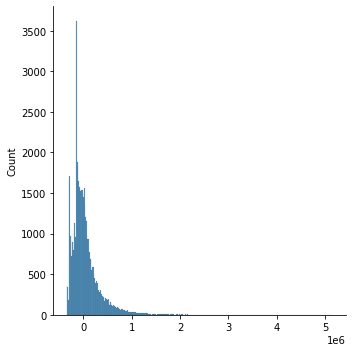

In [47]:
sns.displot(data['GRZHYE'] * 15 - data['DKFFE'])

In [48]:
sparse_feat = sparse_feat + new_feat1
dense_feat = dense_feat + new_feat2
feat_list = sparse_feat + dense_feat

## 模型训练

In [49]:
# 设置一个参数字典, 方便之后记录
args = {}

In [50]:
# 进行数据集划分, 先拆开训练集和测试集, 再从训练集中分离训练集和验证集
train_ = data.iloc[:40000]
test_ = data.iloc[40000:]
test_ = test_.reset_index(drop=True)
trainX = train_[feat_list]
trainY = train_['label'].values
testX = test_[feat_list]

In [58]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from utils import evaluation, submit

#选择StratifiedKFold的原因是标签分布不均衡, 因此需要根据分布来划分
SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=723)

params={
    'learning_rate': 0.05,
    #'max_depth': 10,
    'num_leaves': 31,
    'num_iterations': 10000, 
    'metric': 'auc', 
    'objective': 'binary',
    'random_state': 723, 
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 2,
    #'is_unbalance': True
    #'min_sum_hessian_in_leaf': 50
    }

prediction = np.zeros(testX.shape[0])   # 用来得到五折模型的平均预测值
validationY = np.zeros(trainX.shape[0])
i = 1  # to record the index of k-fold split
print('*************** Training *******************'.center(10))
for train_index, val_index in SKF.split(trainX, trainY):
    print('---------------%d fold----------------' % i)
    X_train, X_val, Y_train, Y_val = trainX.iloc[train_index].reset_index(drop=True), trainX.iloc[val_index].reset_index(drop=True), trainY[train_index], trainY[val_index]
    trn_data = lgb.Dataset(trainX.iloc[train_index].reset_index(drop=True), label=trainY[train_index])
    val_data = lgb.Dataset(trainX.iloc[val_index].reset_index(drop=True), label=trainY[val_index])
    #model = lgb.LGBMClassifier(**params)
    #model.fit(X_train, Y_train, eval_set=[(X_val, Y_val)], eval_metric='auc', early_stopping_rounds=200, verbose=200, categorical_feature=sparse_feat)
    model = lgb.train(params, 
                      trn_data,
                      valid_sets=[trn_data, val_data],
                      early_stopping_rounds=200,
                      verbose_eval=200,
                      categorical_feature=sparse_feat)
    y_ = model.predict(X_val)
    prediction += model.predict(testX)
    validationY[val_index] = model.predict(X_val)
    print('AUC Score: %.5f' % roc_auc_score(Y_val, y_))
    print('TPR Score: %.5f' % evaluation(Y_val, y_))
    i += 1
print('*************** Testing *******************'.center(10))
eval_tpr = round(evaluation(trainY, validationY), 5)
print('TPR Score in validation is: %.5f' % eval_tpr)

*************** Training *******************
---------------1 fold----------------
[LightGBM] [Info] Number of positive: 2206, number of negative: 29794
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.068937 -> initscore=-2.603126
[LightGBM] [Info] Start training from score -2.603126
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.987966	valid_1's auc: 0.935975
Early stopping, best iteration is:
[188]	training's auc: 0.986658	valid_1's auc: 0.936206
AUC Score: 0.93621
TPR Score: 0.43194
---------------2 fold----------------
[LightGBM] [Info] Number of positive: 2206, number of negative: 29794
[Lig

In [59]:
import mlflow

mlflow.set_experiment('OverduePrediction')
experiment = mlflow.get_experiment_by_name('OverduePrediction')

mlflow.set_tracking_uri('./mlruns/')

with mlflow.start_run(experiment_id=experiment.experiment_id, run_name='test'):
    #mlflow.
    mlflow.log_params(params)
    mlflow.log_metric('TPR', eval_tpr)
    #mlflow.sklearn.log_model(model, 'model1')

In [60]:
def submission(res, tpr):
    '''
    按照要求的格式输出结果表格
    输入: 模型预测结果. 注意数据类型为浮点型, 表示逾期的概率.
    输出: 将提交文件存在/submission/文件夹下
    '''
    submit_csv = pd.read_csv(r'./data/submit.csv')
    submit_csv['label'] = res
    time_path = time.strftime("%m%d%H%m", time.localtime())
    csv_path = './submission/' + time_path + '-' + str(tpr) + '.csv'
    submit_csv.to_csv(csv_path, index=False)


In [61]:
submission(prediction, eval_tpr)

In [62]:
train.loc[train['label']==1]['id'].count()

2757

In [56]:
train.describe()

,XINGBIE,CSNY,HYZK,ZHIYE,ZHICHEN,ZHIWU,XUELI,DWJJLX,DWSSHY,GRJCJS,GRZHZT,GRZHYE,GRZHSNJZYE,GRZHDNGJYE,GRYJCE,DWYJCE,DKFFE,DKYE,DKLL,label
count,40000.000000,4.000000e+04,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,1.361900,4.804910e+08,89.974750,89.889300,997.167725,0.000150,98.985150,247.663375,9.612775,4507.734465,1.006300,15020.190993,15316.570596,-117.379254,686.961022,686.961022,190324.265725,156308.760839,2.768083,0.068925
std,0.480868,9.751818e+08,1.461819,2.889914,42.563175,0.012247,1.212422,260.949825,5.541372,2844.622778,0.119836,20189.939168,20061.193795,7968.738147,344.924156,344.924156,75334.858625,77409.960122,0.146709,0.253330
min,0.000000,3.150720e+07,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,787.000000,1.000000,237.000000,237.000000,-240318.745000,246.550000,246.550000,15237.000000,237.000000,2.292000,0.000000
25%,1.000000,3.391776e+08,90.000000,90.000000,999.000000,0.000000,99.000000,110.000000,6.000000,2362.000000,1.000000,1892.468750,2994.080000,-577.803750,411.000000,411.000000,150237.000000,110252.845000,2.708000,0.000000
50%,1.000000,5.205276e+08,90.000000,90.000000,999.000000,0.000000,99.000000,150.000000,10.000000,3887.500000,1.000000,8545.727500,9010.740000,771.800000,616.800000,616.800000,150237.000000,146210.880000,2.708000,0.000000
75%,2.000000,6.338016e+08,90.000000,90.000000,999.000000,0.000000,99.000000,160.000000,14.000000,5831.031250,1.000000,19591.691250,19571.826250,2452.977500,849.060000,849.060000,250237.000000,200844.113750,2.708000,0.000000
max,2.000000,1.903646e+11,90.000000,90.000000,999.000000,1.000000,99.000000,900.000000,20.000000,13692.000000,6.000000,366651.575000,313348.420000,53065.095000,1745.940000,1745.940000,350237.000000,329776.790000,3.575000,1.000000


In [57]:
train_.head(10)

,id,CSNY,XINGBIE,ZHIYE,ZHICHEN,ZHIWU,DWJJLX,DWSSHY,GRZHZT,GRJCJS,GRZHYE,GRZHSNJZYE,GRZHDNGJYE,GRYJCE,DWYJCE,DKFFE,DKYE,DKLL,label,WN,ETF,NY,DKLL_gen,JCBL,YJCZE,DNJCE,DNJCCE,DKLXE,DKFFSEE,DKFFEBL,DKLXE_YJCZE_ratio
0,train_0,7,1,0,0,0,9,12,0,1737.0,3223.515,801.310,837.000,312.00,312.00,175237,154112.935,2.708,0.0,0,0,1,2,0.179620,624.00,2422.205,1585.205,474541.796,-126884.275,3.624139,760.483647
1,train_1,4,2,0,0,0,1,0,0,4894.0,18055.195,53213.220,1065.200,795.84,795.84,300237,298252.945,2.979,0.0,1,0,1,4,0.162615,1591.68,-35158.025,-36223.225,894406.023,-29409.075,1.108590,561.925778
2,train_2,6,1,0,0,0,9,9,0,10297.0,27426.600,13963.140,7230.020,1444.20,1444.20,150237,147339.130,2.708,0.0,0,0,1,2,0.140254,2888.40,13463.460,6233.440,406841.796,261162.000,0.365186,140.853689
3,train_3,3,1,0,0,0,9,7,0,10071.5,111871.130,99701.265,2271.295,1417.14,1417.14,350237,300653.780,2.708,0.0,0,0,1,2,0.140708,2834.28,12169.865,9898.570,948441.796,1327829.950,0.208715,334.632357
4,train_4,4,2,0,0,0,27,14,0,2007.0,237.000,11028.875,35.780,325.50,325.50,150237,145185.010,2.708,0.0,0,0,1,2,0.162182,651.00,-10791.875,-10827.655,406841.796,-146682.000,42.260759,624.948995
5,train_5,3,1,0,0,0,9,14,0,1192.0,9648.315,7388.550,771.800,303.85,303.85,150237,149743.210,2.708,0.0,0,0,1,2,0.254908,607.70,2259.765,1487.965,406841.796,-5512.275,1.038088,669.478025
6,train_6,4,1,0,0,0,11,2,0,7297.0,22846.975,12179.565,5885.000,801.80,801.80,150237,146723.725,2.708,0.0,0,0,1,2,0.109881,1603.60,10667.410,4782.410,406841.796,192467.625,0.438386,253.705286
7,train_7,7,1,0,0,0,9,7,0,1399.0,1808.135,6405.055,1050.400,318.34,318.34,125237,64938.955,2.708,0.0,0,0,1,2,0.227548,636.68,-4596.920,-5647.320,339141.796,-98114.975,4.617539,532.672294
8,train_8,5,2,0,0,0,9,9,0,6408.0,79304.635,52365.820,6161.160,977.52,977.52,300237,270579.955,2.979,0.0,1,0,1,4,0.152547,1955.04,26938.815,20777.655,894406.023,889332.525,0.252391,457.487327
9,train_9,3,2,0,0,0,9,14,0,3573.5,2009.000,61126.175,536.750,637.38,637.38,230237,142296.640,2.708,0.0,0,0,1,2,0.178363,1274.76,-59117.175,-59653.925,623481.796,-200102.000,7.640186,489.097396
